## Armageddon! Wykrywanie asteroid potencjalnie zagrażających Ziemi.

### Cel biznesowy: Budowa aplikacji dla NASA

### Pozyskanie danych:
### https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects


In [1]:

import pandas as pd
import numpy as np
from scipy.stats import trim_mean
from statsmodels import robust
%matplotlib inline
import seaborn as sns
import matplotlib
import matplotlib.pylab as plt


Wczytanie danych

In [2]:
df = pd.read_csv("neo.csv")
df.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [3]:
df.isna().sum()

id                    0
name                  0
est_diameter_min      0
est_diameter_max      0
relative_velocity     0
miss_distance         0
orbiting_body         0
sentry_object         0
absolute_magnitude    0
hazardous             0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


In [5]:
df.columns

Index(['id', 'name', 'est_diameter_min', 'est_diameter_max',
       'relative_velocity', 'miss_distance', 'orbiting_body', 'sentry_object',
       'absolute_magnitude', 'hazardous'],
      dtype='object')

In [6]:
df.shape

(90836, 10)

In [7]:
nulls_summary = pd.DataFrame(df.isnull().any(), columns=['Nulls'])
nulls_summary['Num_of_nulls [qty]'] = pd.DataFrame(df.isnull().sum())
nulls_summary['Num_of_nulls [%]'] = round((df.isnull().mean()*100),2)
print(nulls_summary)

                    Nulls  Num_of_nulls [qty]  Num_of_nulls [%]
id                  False                   0               0.0
name                False                   0               0.0
est_diameter_min    False                   0               0.0
est_diameter_max    False                   0               0.0
relative_velocity   False                   0               0.0
miss_distance       False                   0               0.0
orbiting_body       False                   0               0.0
sentry_object       False                   0               0.0
absolute_magnitude  False                   0               0.0
hazardous           False                   0               0.0


In [8]:
df['orbiting_body'].unique()

array(['Earth'], dtype=object)

In [9]:
df['name'].unique()

array(['162635 (2000 SS164)', '277475 (2005 WK4)', '512244 (2015 YE18)',
       ..., '(2021 WR3)', '(2015 VK142)', '(1999 LV7)'], dtype=object)

In [10]:
df['sentry_object'].unique()

array([False])

Czyszczenie danych

In [11]:
df = df.drop_duplicates()\
    .rename(columns={'hazardous':'hit'})\
    .drop(['id', 'name','orbiting_body','sentry_object'], axis=1)


In [12]:
faetures_names = []      #------ nazwy kolumn do późniejszych opisów
for col in df.columns:
    faetures_names.append(col)
faetures_names = faetures_names[:-1]
X = df.drop(columns='hit')
y = df['hit']

In [13]:
df.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hit
0,1.198271,2.679415,13569.249224,5.483974e+07,16.73,False
1,0.265800,0.594347,73588.726663,6.143813e+07,20.00,True
2,0.722030,1.614507,114258.692129,4.979872e+07,17.83,False
3,0.096506,0.215794,24764.303138,2.543497e+07,22.20,False
4,0.255009,0.570217,42737.733765,4.627557e+07,20.09,True


In [14]:
#Zmiana zależnej zmiennej kategorycznej na numeryczną

df['hit']=df['hit'].replace(True, 1)
df['hit']=df['hit'].replace(False, 0)

df['hit'].value_counts()


0    81996
1     8840
Name: hit, dtype: int64

In [15]:
df.dtypes

est_diameter_min      float64
est_diameter_max      float64
relative_velocity     float64
miss_distance         float64
absolute_magnitude    float64
hit                     int64
dtype: object

In [16]:
df.describe()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hit
count,90836.000000,90836.000000,90836.000000,9.083600e+04,90836.000000,90836.000000
mean,0.127432,0.284947,48066.918918,3.706655e+07,23.527103,0.097318
std,0.298511,0.667491,25293.296961,2.235204e+07,2.894086,0.296392
min,0.000609,0.001362,203.346433,6.745533e+03,9.230000,0.000000
25%,0.019256,0.043057,28619.020645,1.721082e+07,21.340000,0.000000
50%,0.048368,0.108153,44190.117890,3.784658e+07,23.700000,0.000000
75%,0.143402,0.320656,62923.604633,5.654900e+07,25.700000,0.000000
max,37.892650,84.730541,236990.128088,7.479865e+07,33.200000,1.000000


In [17]:
df.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hit
0,1.198271,2.679415,13569.249224,5.483974e+07,16.73,0
1,0.265800,0.594347,73588.726663,6.143813e+07,20.00,1
2,0.722030,1.614507,114258.692129,4.979872e+07,17.83,0
3,0.096506,0.215794,24764.303138,2.543497e+07,22.20,0
4,0.255009,0.570217,42737.733765,4.627557e+07,20.09,1


### Analiza danych w celu wykrycia dodatkowych informacji  - EDA.

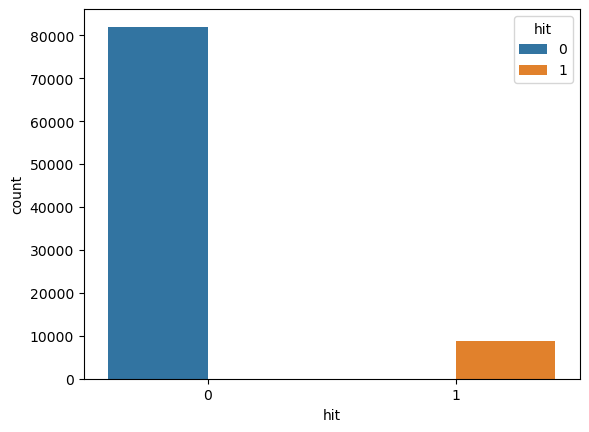

In [18]:
sns.countplot(x='hit',data=df, hue="hit")
plt.show()

Na pierwszy rzut oka można zauważyć dużą dysproporcję w zbiorze ze względu na klasyfikację obiektów.

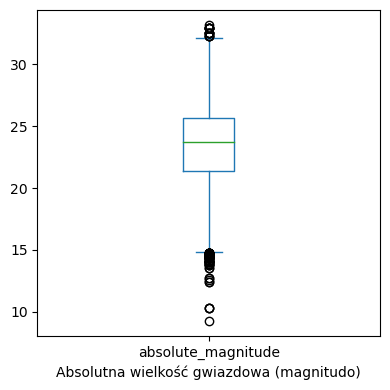

In [19]:
ax = (df['absolute_magnitude']).plot.box(figsize=(4,4))
ax.set_xlabel('Absolutna wielkość gwiazdowa (magnitudo)')


plt.tight_layout()
plt.show()

Z tego wykresu można odczytać, że mediana absolutnej wielkości gwiazdowej wynosi  23,5 magnitudo. Połowa wyników mieści się w zakresie od 21, 3 do 25,7. 
Występują też wartości odstające powyżej 33 magnitudo oraz  poniżej 15. Max wartość to 33 magnitudo, minimalna 9,2 magnitudo.

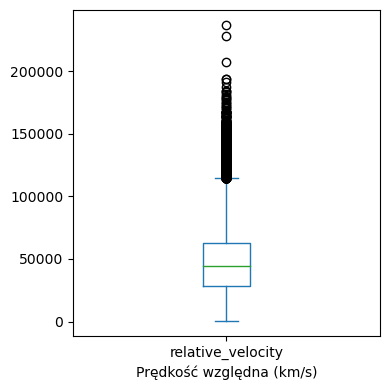

In [20]:
ax = (df['relative_velocity']).plot.box(figsize=(4,4))
ax.set_xlabel('Prędkość względna (km/s)')

plt.tight_layout()
plt.show()

Analogiczne wnioski można wyciągnąć z powyższego wykresu pudełkowego, który przedstawia prędkość względną.
Na nim widzimy, że:
wartość średnia – 48 067 km/s;
połowa wyników mieści się w przedziale – 28 619,00 – 62 923,60 km/s;
występują wartości odstające o dużych wartościach.

array([[<Axes: title={'center': 'est_diameter_min'}>,
        <Axes: title={'center': 'est_diameter_max'}>],
       [<Axes: title={'center': 'relative_velocity'}>,
        <Axes: title={'center': 'miss_distance'}>],
       [<Axes: title={'center': 'absolute_magnitude'}>,
        <Axes: title={'center': 'hit'}>]], dtype=object)

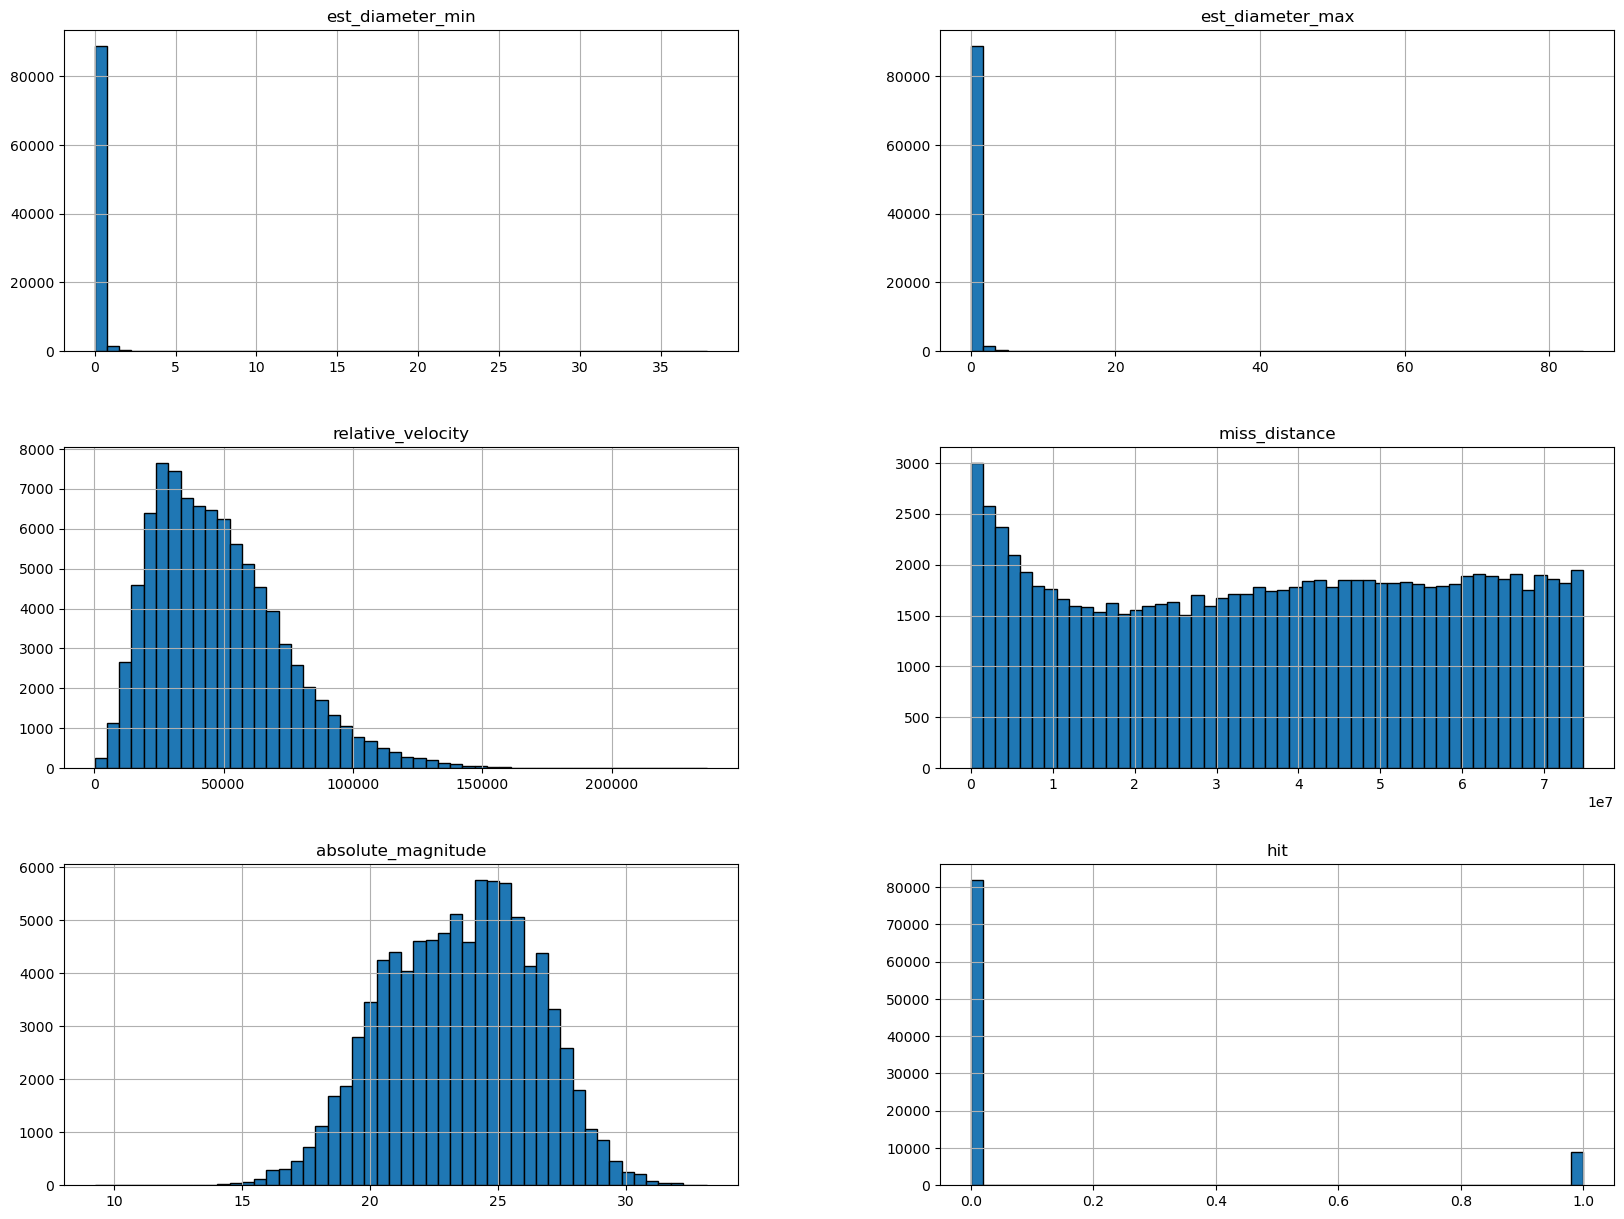

In [21]:
df.hist(figsize=(20,15), bins=50, edgecolor='k')


# odległość trafiającego pocisku od celu -----> miss_distance
# Prędkość względna --------> relative_velocity
# Absolutna wielkość gwiazdowa ---------> absolute_magnitude
# szacowana średnica min/ max --------> est_diameter_min / max



C:\Users\troch\AppData\Local\Temp\ipykernel_17944\3569296696.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.miss_distance)


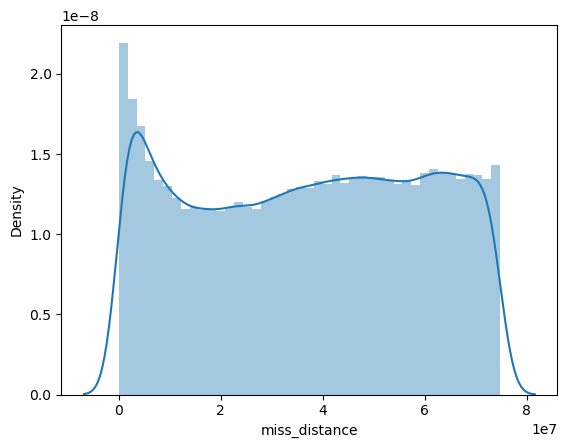

In [22]:
sns.distplot(df.miss_distance)
plt.show()

Text(0.5, 0, 'Absolutna wielkość gwiazdowa (magnitudo)')

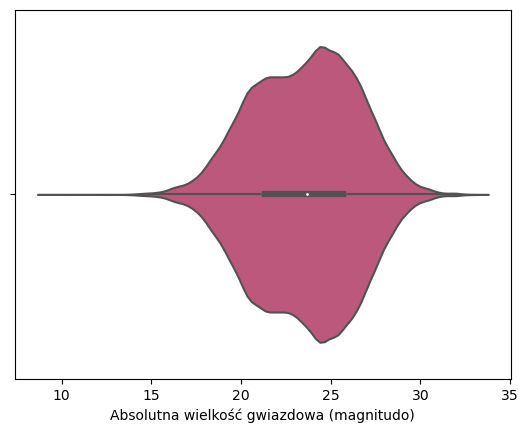

In [23]:
ax = sns.violinplot(x="absolute_magnitude", hue='hit',
                 data=df, palette="plasma")
ax.set_xlabel('Absolutna wielkość gwiazdowa (magnitudo)')

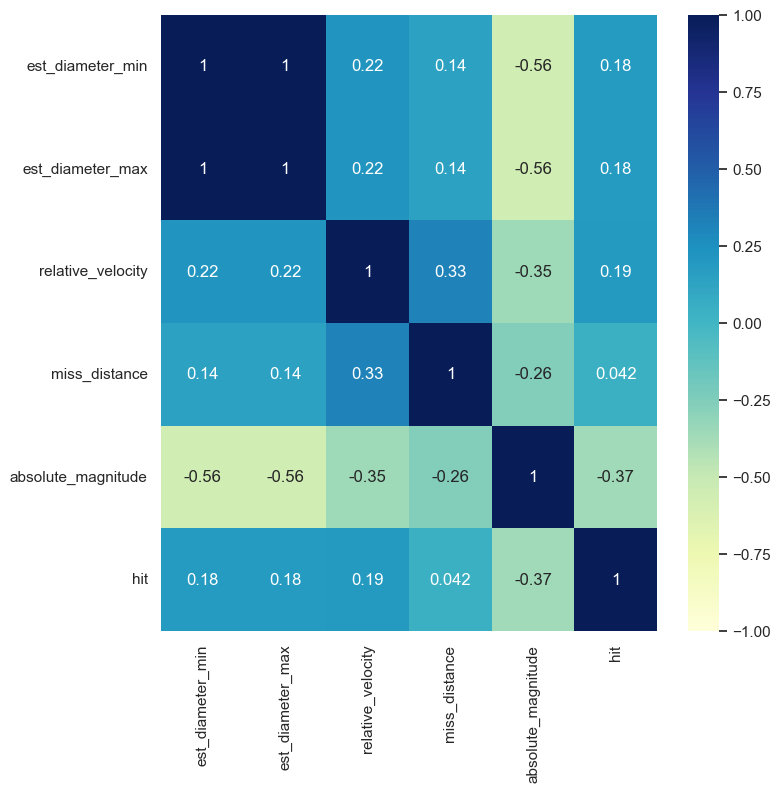

In [24]:
#sns.heatmap(df.corr(),vmin=-1,vmax=1,cmap='YlGnBu')
#plt.show()

correlation_matrix = np.round(df.corr(),4) # policzenie korelacji
sns.set(rc={'figure.figsize':(8,8)}) # określenie rozmiaru rysunku
sns.heatmap(correlation_matrix, vmin=-1.,vmax=1.,annot=True, cmap='YlGnBu') # wykonanie wykresu

pass

Po spojrzeniu na mapę korelacji widać, że dwie zmienne są ze sobą silnie skorelowane. Jest to maksymalna i minimalna szacowana średnica mierzona w kilometrach.

array([[<Axes: xlabel='est_diameter_min', ylabel='est_diameter_min'>,
        <Axes: xlabel='est_diameter_max', ylabel='est_diameter_min'>,
        <Axes: xlabel='relative_velocity', ylabel='est_diameter_min'>,
        <Axes: xlabel='miss_distance', ylabel='est_diameter_min'>,
        <Axes: xlabel='absolute_magnitude', ylabel='est_diameter_min'>,
        <Axes: xlabel='hit', ylabel='est_diameter_min'>],
       [<Axes: xlabel='est_diameter_min', ylabel='est_diameter_max'>,
        <Axes: xlabel='est_diameter_max', ylabel='est_diameter_max'>,
        <Axes: xlabel='relative_velocity', ylabel='est_diameter_max'>,
        <Axes: xlabel='miss_distance', ylabel='est_diameter_max'>,
        <Axes: xlabel='absolute_magnitude', ylabel='est_diameter_max'>,
        <Axes: xlabel='hit', ylabel='est_diameter_max'>],
       [<Axes: xlabel='est_diameter_min', ylabel='relative_velocity'>,
        <Axes: xlabel='est_diameter_max', ylabel='relative_velocity'>,
        <Axes: xlabel='relative_velocity',

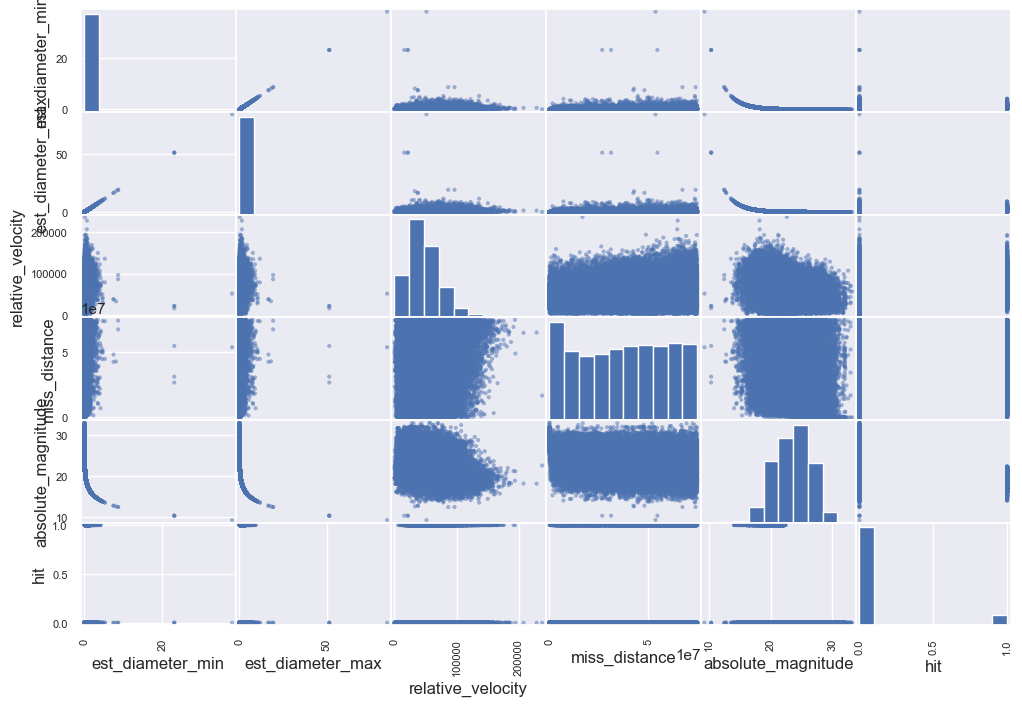

In [25]:
from pandas.plotting import scatter_matrix

attributes = ["est_diameter_min","est_diameter_max","relative_velocity","miss_distance","absolute_magnitude", "hit"] 
scatter_matrix(df[attributes], figsize=(12, 8))


C:\Users\troch\AppData\Local\Temp\ipykernel_17944\217211639.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i]);
C:\Users\troch\AppData\Local\Temp\ipykernel_17944\217211639.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i]);
C:\Users\troch\AppData\Local\Temp\ipykernel_17944\217211

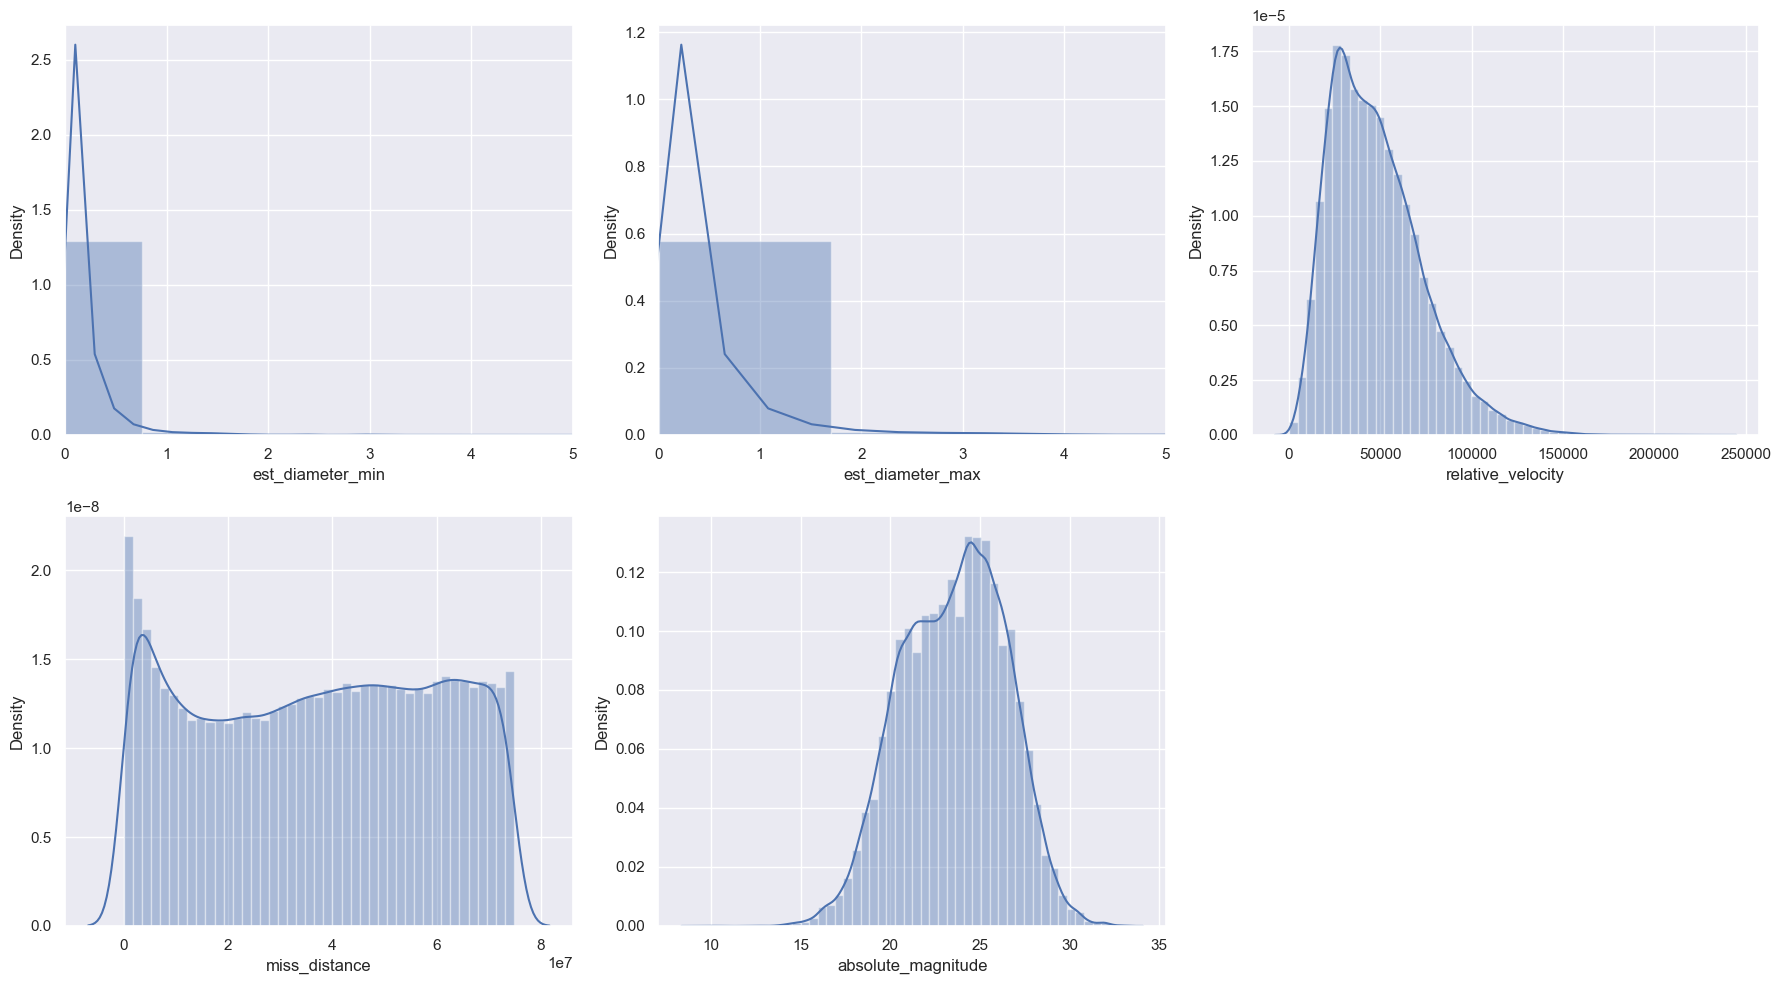

In [26]:
# Making mulptiple subplots
plt.figure(figsize= (18,10));
counter = 1
for i in faetures_names:
    plt.subplot(2,3,counter);
    sns.distplot(df[i]);
    counter +=1
    if counter <4:
        plt.xlim(0,5)
plt.tight_layout();
plt.show();

Histogramy dla poszczególnych zmiennych obrazują częstości występowania na osi y (w tym przypadku proporcje), a wartości zmiennych na osi x, co pozwala zobrazować rozkład danych.
Powyżej wygładzona wersja histogramu, bazująca na jądrowym estymatorze gęstości. Przedstawia rozkład wartości danych jako linię ciągłą.


C:\Users\troch\AppData\Local\Temp\ipykernel_17944\557100968.py:1: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.catplot(x = "hit", y = "est_diameter_min", palette = "Set2", data = df, aspect = 1.5, alpha=0.2)
C:\Users\troch\AppData\Local\Temp\ipykernel_17944\557100968.py:2: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.catplot(x = "hit", y = "est_diameter_max", palette = "Set2", data = df, aspect = 1.5, alpha=0.2)
C:\Users\troch\AppData\Local\Temp\ipykernel_17944\557100968.py:3: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.catplot(x = "hit", y = "relative_velocity", palette = "Set2", data = df, aspect = 1.5, alpha=0.2)
C:\Users\troch\AppData\Local\Temp\ipykernel_17944\557100968.py:4: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.catplot(x = "hit", y = "miss_distance", palette = "Set2", data = df, aspect = 1.5, alpha=0.2)
C:\Users\troch\AppData\Local\Temp\ipyk

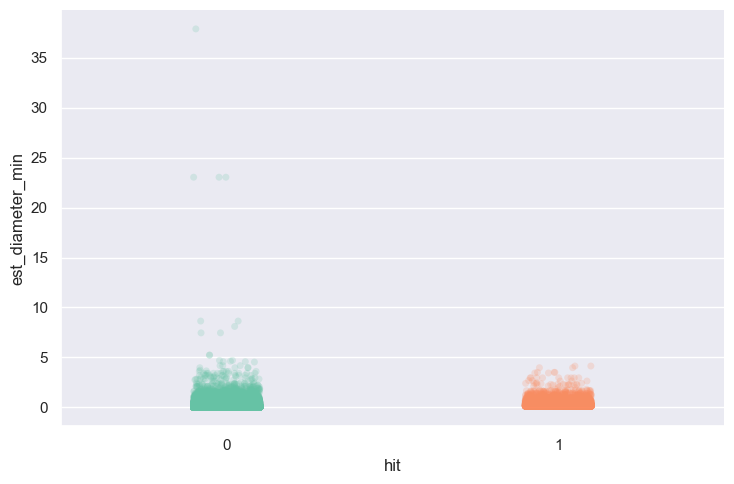

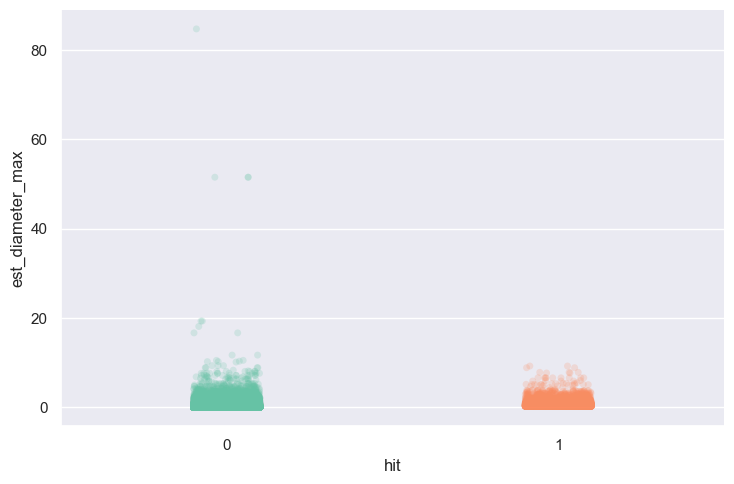

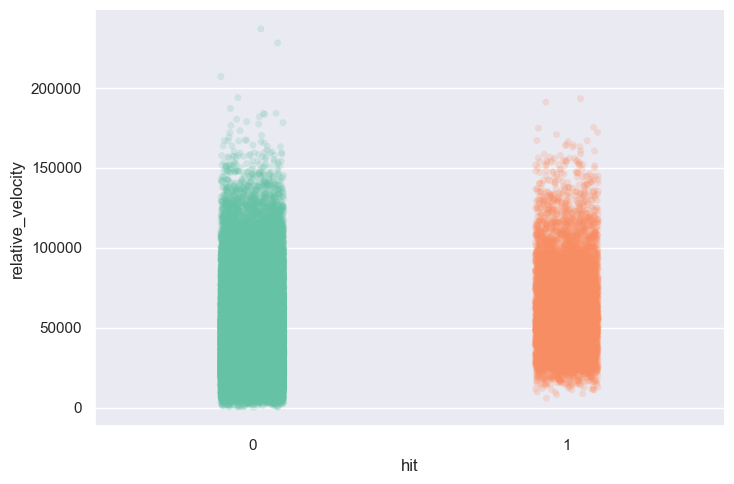

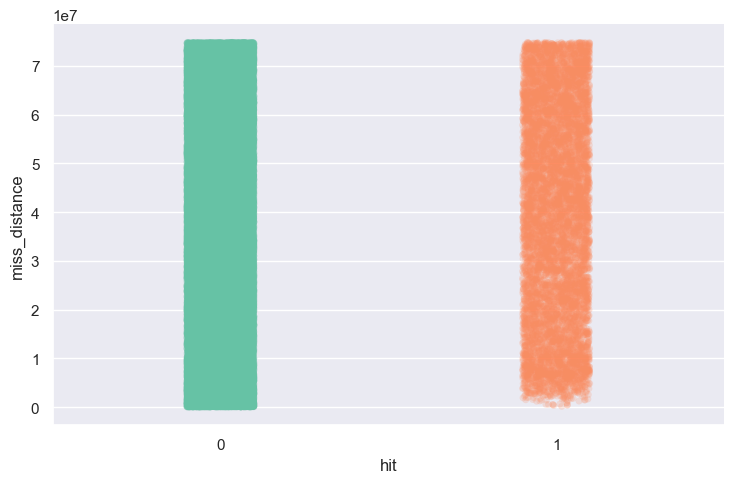

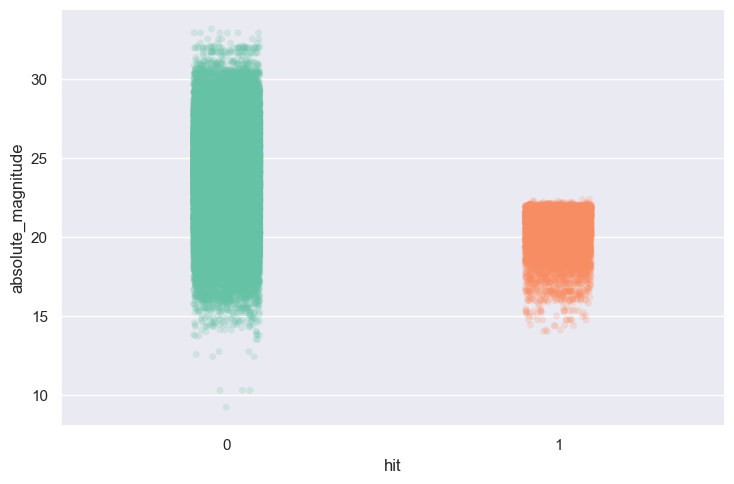

In [27]:
sns.catplot(x = "hit", y = "est_diameter_min", palette = "Set2", data = df, aspect = 1.5, alpha=0.2)
sns.catplot(x = "hit", y = "est_diameter_max", palette = "Set2", data = df, aspect = 1.5, alpha=0.2)
sns.catplot(x = "hit", y = "relative_velocity", palette = "Set2", data = df, aspect = 1.5, alpha=0.2)
sns.catplot(x = "hit", y = "miss_distance", palette = "Set2", data = df, aspect = 1.5, alpha=0.2)
sns.catplot(x = "hit", y = "absolute_magnitude", palette = "Set2", data = df, aspect = 1.5, alpha=0.2)

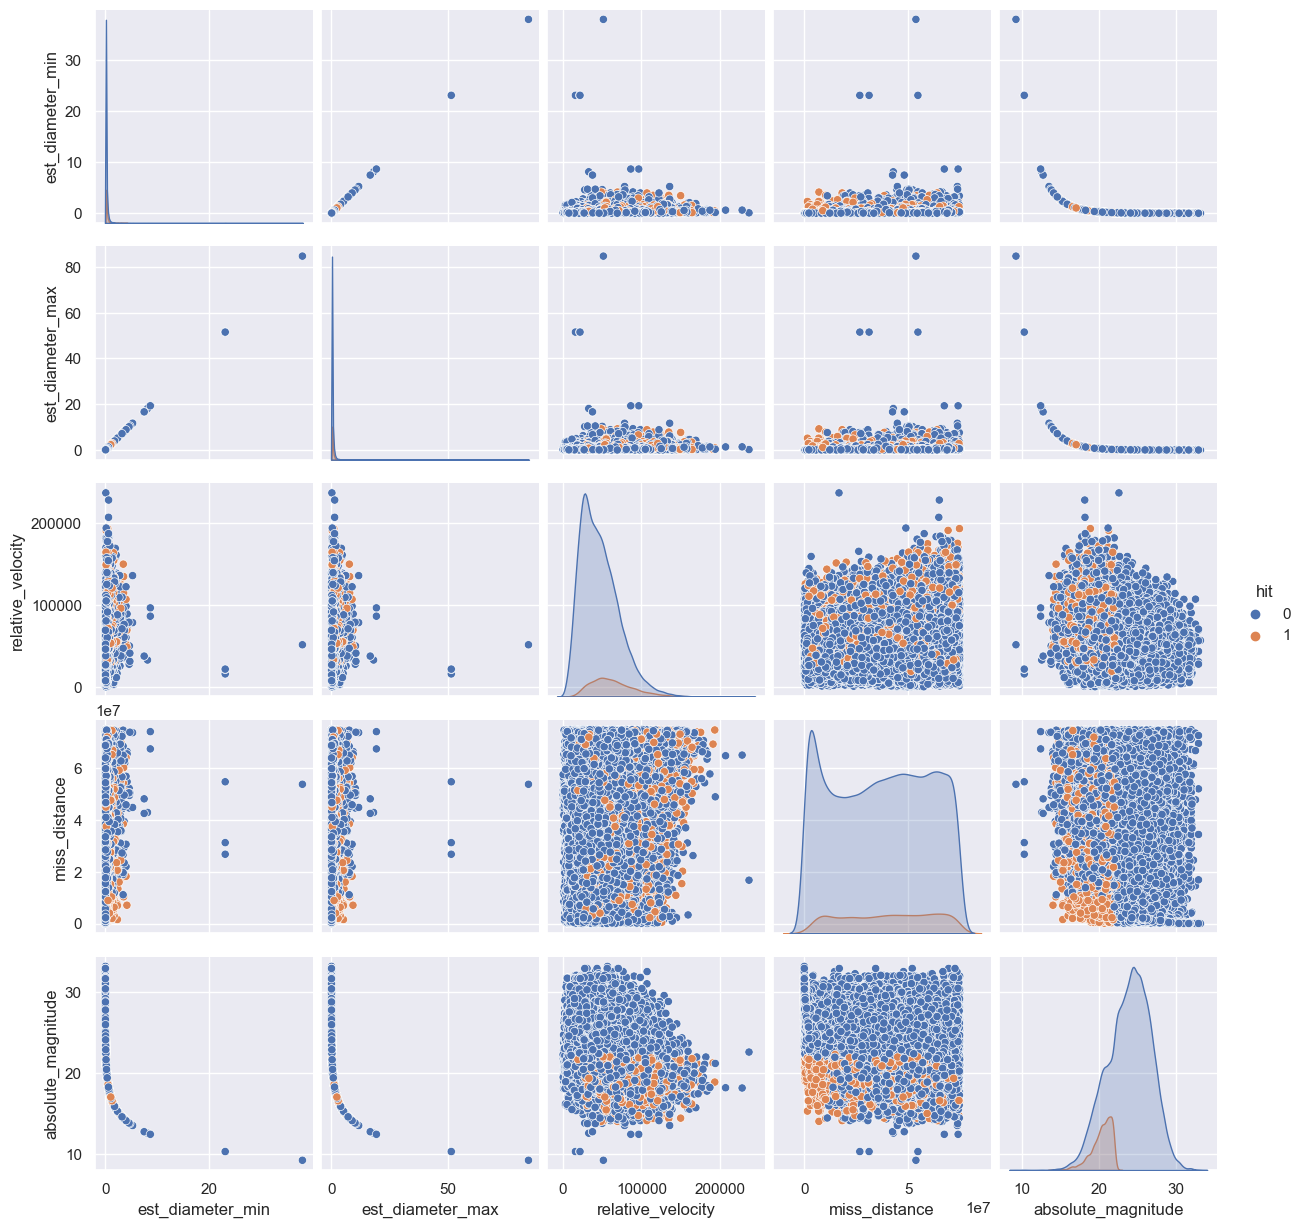

In [28]:
sns.pairplot(df, hue = "hit")
sns.set(font_scale = 1.2)


Sposobem wizualizacji związku pomiędzy dwoma mierzonymi zmiennymi jest wykres punktowy. Oś x reprezentuje jedną zmienną, a oś y drugą; każdy punkt wykresu jest wierszem.
Można zauważyć jak dane są zgrupowane. 
Po przekątnej pokazane są wykresy gęstości w zależności od skategoryzowania zmiennej.
Z powyższego wykresu można odczytać, że rozkład gęstości dla absolutnej wielkości gwiazdowej jest proporcjonalny w zależności od skategoryzowania 0/1.
Oraz w przedziale powyżej 23 magnitude nie występują wartości skategoryzowane jako klasa 1.


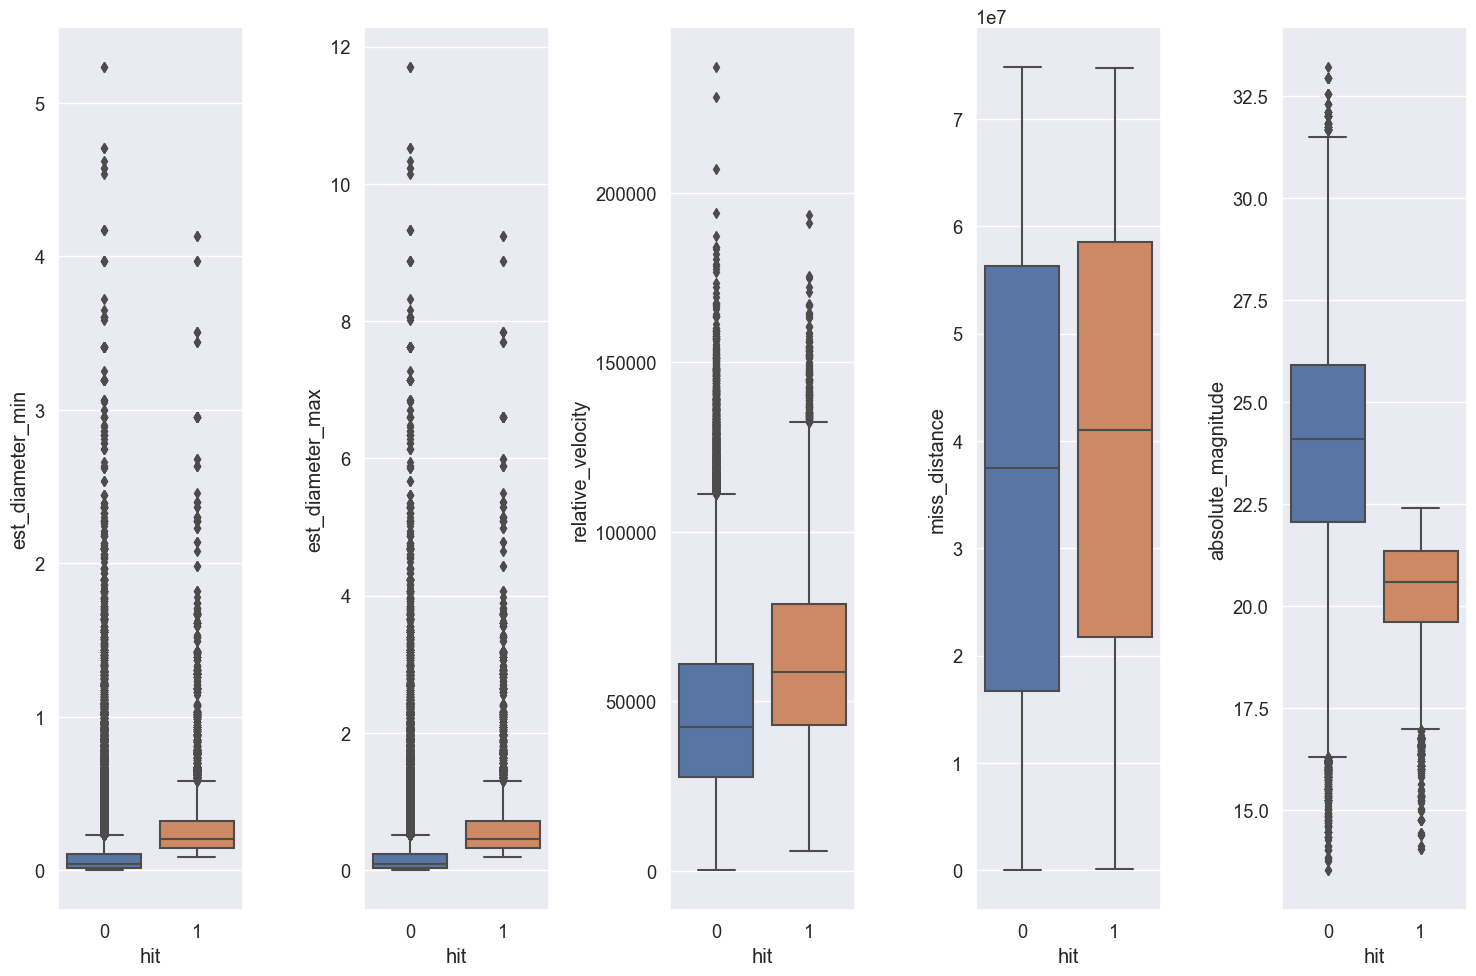

In [29]:
nowydf = df.copy()
nowydf = df[df['est_diameter_max'] < 15 ]
counter=1
plt.figure(figsize=(15,10))
for i in faetures_names:
    plt.subplot(1,5,counter)
    sns.boxplot(x='hit',y=i,data=nowydf)
    counter+=1
    
plt.tight_layout()
plt.show()

Wykresy pudełkowe pokazują podstawowe statystyki w zależności od zmiennej skategoryzowanej. 
Z powyższego wykresy można między innymi odczytać wartości średnie dla poszczególnych klas, w jakich przedziałach znajdują się połowa wartości danych oraz wartości odstające.
Największa dysproporcję między wynikami w klasach prezentuje absolutna wielkość gwiazdowa.
Z wykresu można odczytać, że uderzenie jest możliwe jedynie dla małych wartości mieszczących się poniżej 23 magnitudo oraz poniżej 50 % wartości znajdujących się w klasie 0

 ### Uogólnione modele liniowe -GML

In [30]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [31]:
formula = 'hit ~ est_diameter_min + est_diameter_max + relative_velocity +  miss_distance +  absolute_magnitude'
model_glm = smf.glm(formula = formula, data=df, family=sm.families.Binomial())
result = model_glm.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    hit   No. Observations:                90836
Model:                            GLM   Df Residuals:                    90831
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20285.
Date:                Sun, 21 May 2023   Deviance:                       40570.
Time:                        23:17:09   Pearson chi2:                 3.96e+06
No. Iterations:                     8   Pseudo R-squ. (CS):             0.1744
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             24.2809      0

P>|z| jest jedną z najważniejszych statystyk w podsumowaniu GML. Wykorzystuje statystykę z do obliczenia wartości p , która jest miarą prawdopodobieństwa, że współczynnik jest mierzony przez nasz model przez przypadek. 
Progiem istotności statystycznej jest wartość równa bądź mniejsza 5% (p<0,05).

Zmienna hit nie ma wpływ na zmienne zależne, nasze wyniki nie są generowane przez przypadek.

[0,025 i 0,975] to pomiary wartości naszych współczynników w granicach 95% naszych danych lub w granicach dwóch odchyleń standardowych. Poza tymi wartościami można ogólnie uznać wartości odstające.

###  Przygotowanie danych w sposób uwidaczniający wzorce wykorzystywane przez algorytmy uczenia maszynowego:


 - Oczyszczanie danych
 - Dobór cech
 - Skalowanie cech - standaryzacja cechy.

Podział na zbiór treningowy i testowy

In [32]:
from sklearn.model_selection import train_test_split

X = df[['est_diameter_min', 'relative_velocity', 'miss_distance', 'absolute_magnitude']]
y = df['hit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123, stratify=y)

In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [34]:
print (y_train.value_counts(), '\n \n \n', y_test.value_counts())

0    54937
1     5923
Name: hit, dtype: int64 
 
 
 0    27059
1     2917
Name: hit, dtype: int64


SMOTE

Jednym ze sposobów walki z problemem nadpróbkowania jest generowanie nowych próbek w klasach, które są niedostatecznie reprezentowane. 
SMOTE może łączyć wartości wewnętrzne i odstające.
Algorytm SMOTE znajduje rekord podobny do rekordu i tworzy syntetyczny rekord, którego waga jest uśredniana losowo na bazie wag rekordu oryginalnego i najbliższych sąsiadów; wagi generowane są niezależnie dla każdego predykatora. Liczba stworzonych syntetycznych, nadpróbkowanych rekordów zależy od wskaźnika nadpróbkowania wymaganego do oszacowanego zbilansowania w odniesieniu do klasy wynikowej. 


In [35]:
from imblearn.over_sampling import SMOTE

X_train, y_train = SMOTE().fit_resample(X_train, y_train)

In [36]:
print (y_train.value_counts(), '\n \n \n', y_test.value_counts())

0    54937
1    54937
Name: hit, dtype: int64 
 
 
 0    27059
1     2917
Name: hit, dtype: int64


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


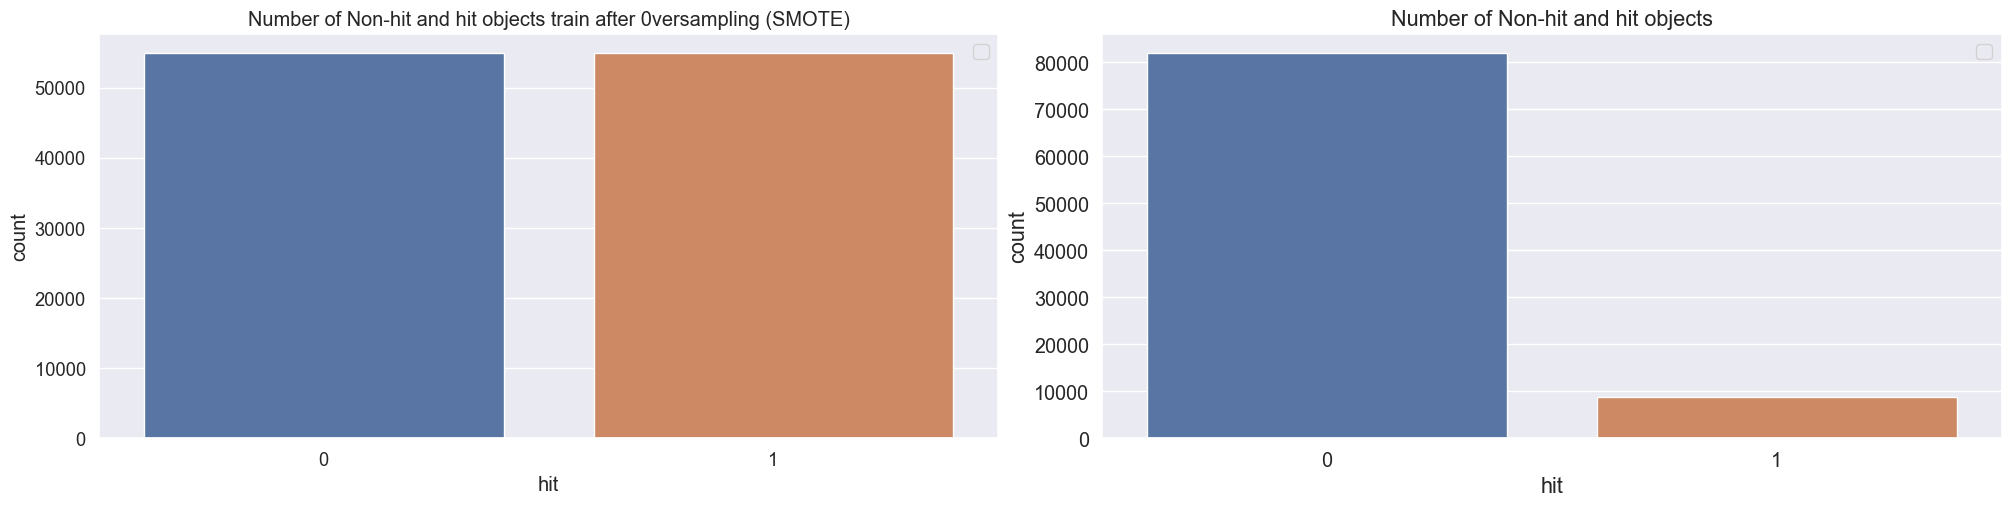

In [37]:
import matplotlib.gridspec as gridspec

fig = plt.figure(constrained_layout = True, figsize = (20,9))

grid = gridspec.GridSpec(ncols = 4, nrows = 2, figure = fig)

ax1 = fig.add_subplot(grid[0, :2])
ax1.set_title('Number of Non-hit and hit objects train after 0versampling (SMOTE)')
sns.set(font_scale = 1.3)

sns.countplot(x=y_train, data=df)



ax1.legend()

ax2 = fig.add_subplot(grid[0, 2:])
ax2.set_title('Number of Non-hit and hit objects')
sns.countplot(x='hit',data=df)
sns.set(font_scale = 1.3)

ax2.legend()
plt.show();

### Sprawdzenie wielu modeli i stworzenie krótkiej listy najwydajniejszych z nich.

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

Regresja logistyczna

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

log_reg = LogisticRegression(random_state=123, max_iter=200)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
y_pred_proba_log_reg = log_reg.predict_proba(X_test)
y_fit_train_log_reg = log_reg.predict(X_train)

In [40]:
from sklearn.metrics import accuracy_score, f1_score,precision_score,recall_score, classification_report
def evaluate(y_test,y_pred, model):
    print("Accuracy Score(train):", accuracy_score(model.predict(X_train), y_train))
    print("Accuracy Score(test):", accuracy_score(model.predict(X_test), y_test)) 
    print('Accuracy Score:',accuracy_score(y_test,y_pred))
    print('F1_score:',f1_score(y_test,y_pred))
    print('Precision:',precision_score(y_test,y_pred))
    print('Recall:',recall_score(y_test,y_pred))
    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(cm).plot()
    print('Classification report:\n',classification_report(y_test,y_pred))



Accuracy Score(train): 0.5741940768516665
Accuracy Score(test): 0.40439017880971445
Accuracy Score: 0.40439017880971445
F1_score: 0.2028040721557421
Precision: 0.11658709379331587
Recall: 0.7785395954748029
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.36      0.52     27059
           1       0.12      0.78      0.20      2917

    accuracy                           0.40     29976
   macro avg       0.53      0.57      0.36     29976
weighted avg       0.86      0.40      0.49     29976

[0.7785395954748029]


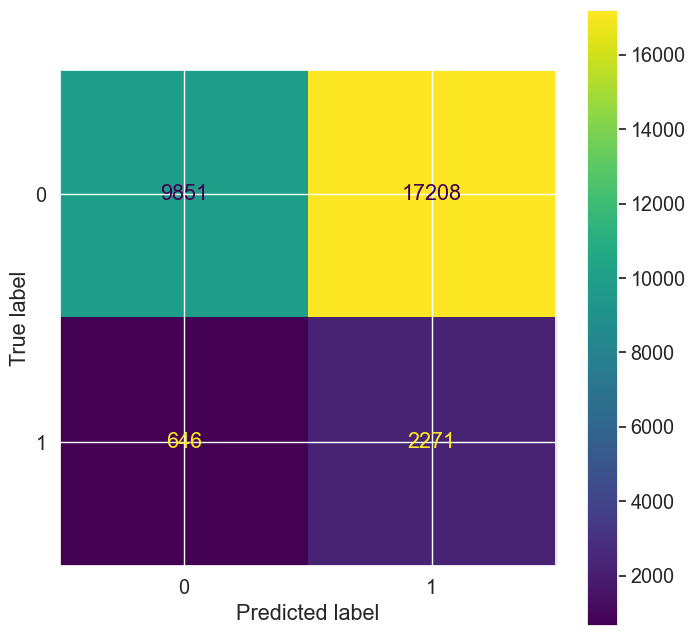

In [41]:
evaluate(y_test, y_pred_log_reg, log_reg)
recall_list = []
recall_list.append(recall_score(y_test, y_pred_log_reg))
print(recall_list)



In [42]:
from sklearn.metrics import roc_curve, auc

def roc_curve_plot(y_test, y_scores, method):
    fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = f'AUC {method} = %0.2f' % roc_auc)
    plt.legend()
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve of ' + method)
    plt.rcParams['figure.figsize']=[10,5]
    return roc_auc

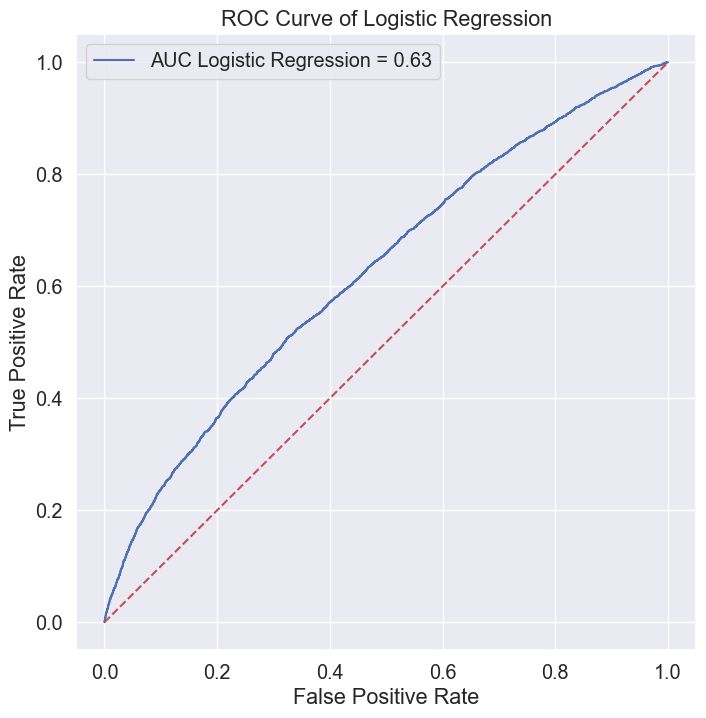

In [43]:
y_scores_log_reg = log_reg.predict_proba(X_test)
auc_log_reg = round(roc_curve_plot(y_test, y_scores_log_reg, 'Logistic Regression')*100,2)

Gaussian Naive Bayes

In [44]:

naive = GaussianNB()
naive.fit(X_train, y_train)
y_pred_naive = naive.predict(X_test)
y_pred_proba_naive = naive.predict_proba(X_test)
y_fit_train_naive = naive.predict(X_train)

Accuracy Score(train): 0.6206836922292808
Accuracy Score(test): 0.6311048839071257
Accuracy Score: 0.6311048839071257
F1_score: 0.2427064785645802
Precision: 0.1516474112109542
Recall: 0.6074734316078162
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.63      0.76     27059
           1       0.15      0.61      0.24      2917

    accuracy                           0.63     29976
   macro avg       0.54      0.62      0.50     29976
weighted avg       0.86      0.63      0.71     29976

[0.7785395954748029, 0.6074734316078162]


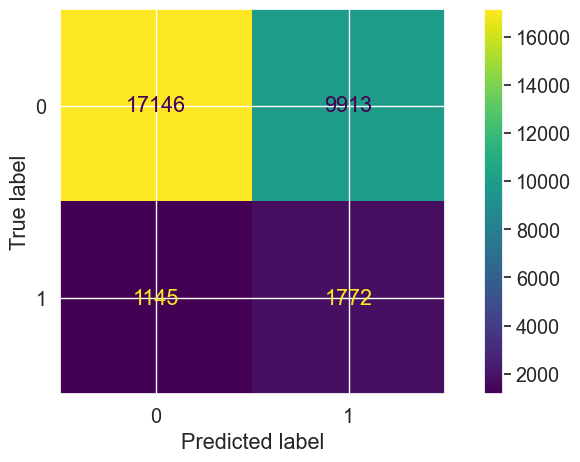

In [45]:
evaluate(y_test, y_pred_naive, naive)

recall_list.append(recall_score(y_test, y_pred_naive))
print(recall_list)


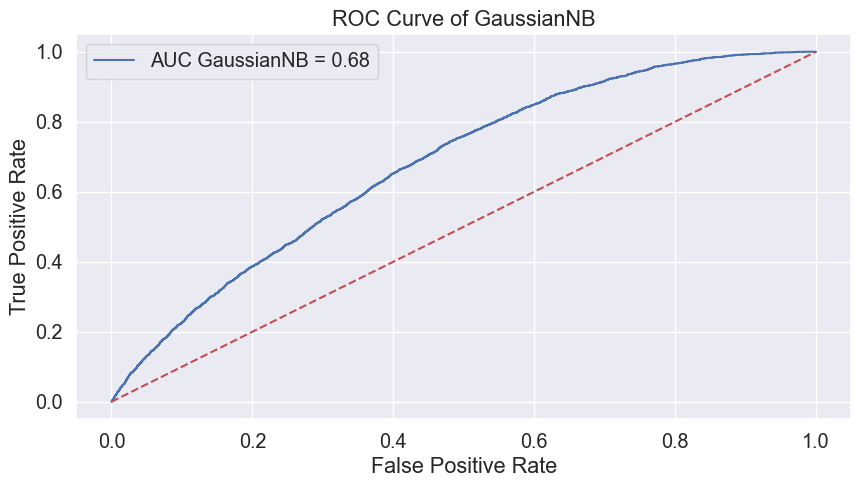

In [46]:
y_scores_naive = naive.predict_proba(X_test)
auc_naive = round(roc_curve_plot(y_test, y_scores_naive, 'GaussianNB')*100,2)

Decision Tree Classifier - gini

In [47]:
tree_g = DecisionTreeClassifier(random_state=123, criterion='gini', max_depth=5)
tree_g.fit(X_train, y_train)
y_pred_tree_g = tree_g.predict(X_test)
y_pred_proba_tree_g = tree_g.predict_proba(X_test)
y_fit_train_tree_g = tree_g.predict(X_train)

Accuracy Score(train): 0.8844949669621567
Accuracy Score(test): 0.7923005070723246
Accuracy Score: 0.7923005070723246
F1_score: 0.47451046590141793
Precision: 0.31474638898219687
Recall: 0.9636612958519026
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.77      0.87     27059
           1       0.31      0.96      0.47      2917

    accuracy                           0.79     29976
   macro avg       0.65      0.87      0.67     29976
weighted avg       0.93      0.79      0.83     29976

[0.7785395954748029, 0.6074734316078162, 0.9636612958519026]


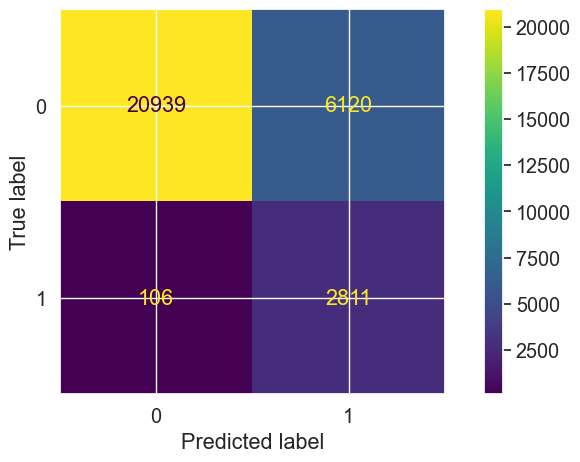

In [48]:
evaluate(y_test, y_pred_tree_g, tree_g)

recall_list.append(recall_score(y_test, y_pred_tree_g))
print(recall_list)

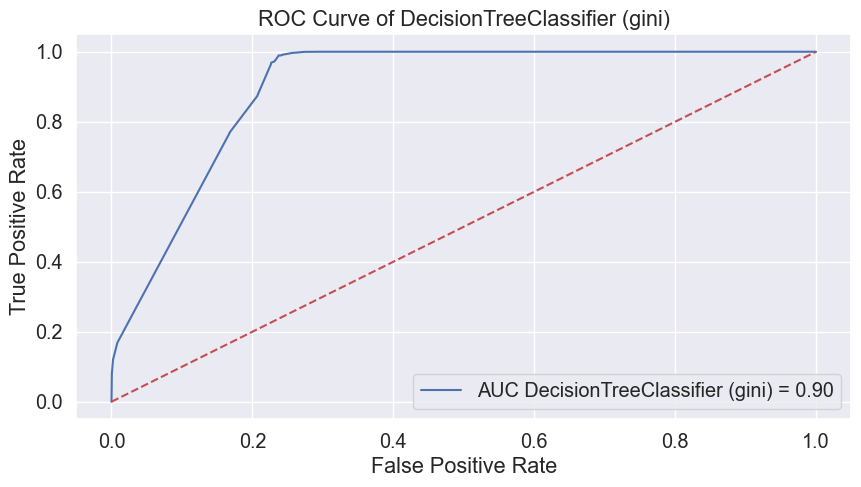

In [49]:
y_scores_tree_g = tree_g.predict_proba(X_test)
auc_tree_g = round(roc_curve_plot(y_test, y_scores_tree_g, 'DecisionTreeClassifier (gini)')*100,2)

Decision Tree Classifier - entropy

In [50]:
tree_e = DecisionTreeClassifier(random_state=123, criterion='entropy', max_depth=5)
tree_e.fit(X_train, y_train)
y_pred_tree_e = tree_e.predict(X_test)
y_pred_proba_tree_e = tree_e.predict_proba(X_test)
y_fit_train_tree_e = tree_e.predict(X_train)

Accuracy Score(train): 0.8834210095199956
Accuracy Score(test): 0.7939017880971444
Accuracy Score: 0.7939017880971444
F1_score: 0.47590770274855787
Precision: 0.3161988501859993
Recall: 0.9616043880699349
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.78      0.87     27059
           1       0.32      0.96      0.48      2917

    accuracy                           0.79     29976
   macro avg       0.66      0.87      0.67     29976
weighted avg       0.93      0.79      0.83     29976

[0.7785395954748029, 0.6074734316078162, 0.9636612958519026, 0.9616043880699349]


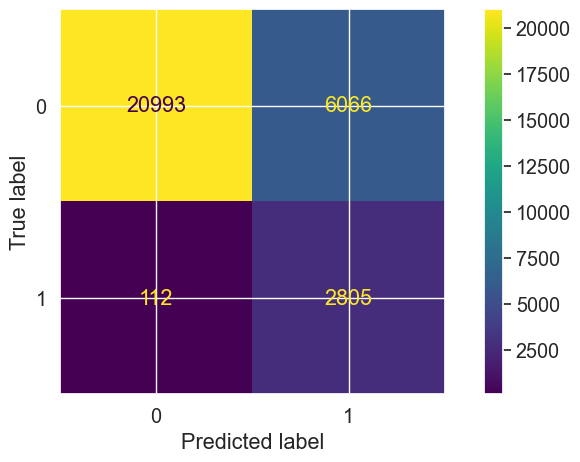

In [51]:
evaluate(y_test, y_pred_tree_e, tree_e )

recall_list.append(recall_score(y_test, y_pred_tree_e))
print(recall_list)



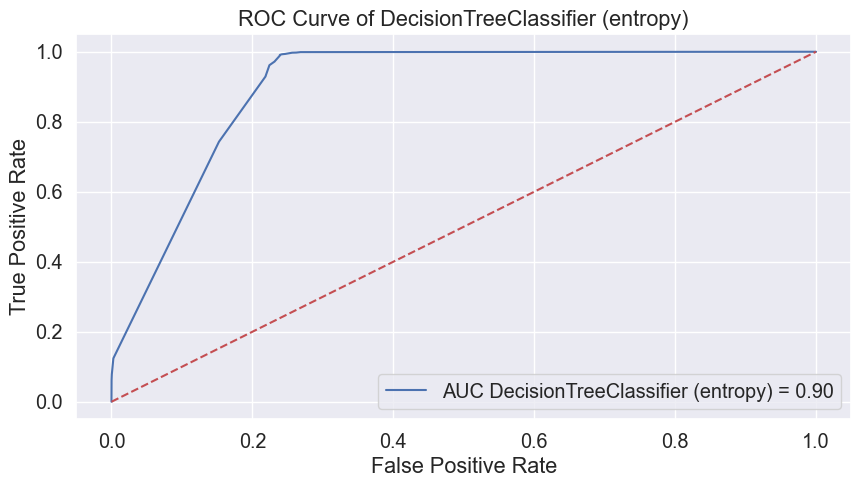

In [52]:
y_scores_tree_e = tree_e.predict_proba(X_test)
auc_tree_e = round(roc_curve_plot(y_test, y_scores_tree_e, 'DecisionTreeClassifier (entropy)')*100,2)

EXTRA TREES CLASSIFIER

In [53]:
params3 = {'n_estimators': 500,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 8,
 'max_depth': 16,
 'criterion': 'entropy'}

ET_CLF = ExtraTreesClassifier(**params3)
ET_CLF.fit(X_train, y_train)
ET_pred = ET_CLF.predict(X_test)
ET_pred_p = ET_CLF.predict_proba(X_test)
ET_pred_t = ET_CLF.predict(X_train)

Accuracy Score(train): 0.9001128565447695
Accuracy Score(test): 0.8049439551641313
Accuracy Score: 0.8049439551641313
F1_score: 0.4838908994615589
Precision: 0.3258440323347599
Recall: 0.939664038395612
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.79      0.88     27059
           1       0.33      0.94      0.48      2917

    accuracy                           0.80     29976
   macro avg       0.66      0.87      0.68     29976
weighted avg       0.93      0.80      0.84     29976



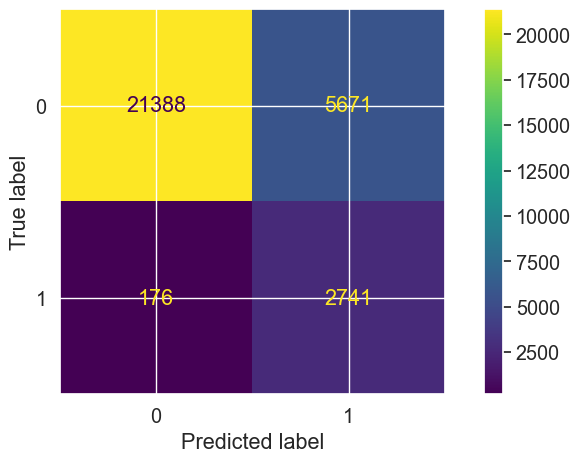

In [54]:
evaluate(y_test, ET_pred, ET_CLF)
recall_list.append(recall_score(y_test, ET_pred))

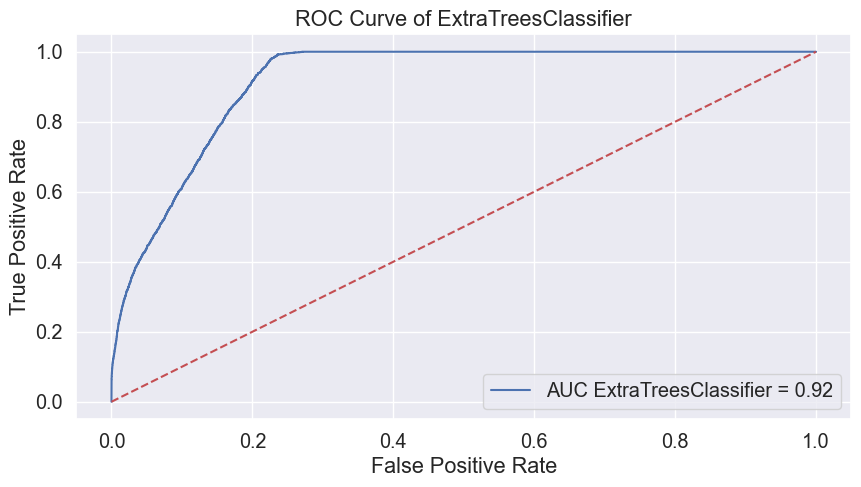

In [55]:
auc_Extratrees = round(roc_curve_plot(y_test, ET_pred_p, 'ExtraTreesClassifier')*100,2)

Random Forest Classifier

In [56]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [57]:
params = {'n_estimators': 5,
 'min_samples_leaf': 6,
 'max_leaf_nodes': 6,
 'max_features': 6,
 'max_depth': 3,
 'criterion': 'gini'}
RFC = RandomForestClassifier(**params)
RFC.fit(X_train,y_train)

RandomForestClassifier(max_depth=3, max_features=6, max_leaf_nodes=6,
                       min_samples_leaf=6, n_estimators=5)

In [58]:

y_pred_forest = RFC.predict(X_test)
y_pred_proba_forest = RFC.predict_proba(X_test)
y_fit_train_forest = RFC.predict(X_train)

Accuracy Score(train): 0.8833299961774396
Accuracy Score(test): 0.7913997864958634
Accuracy Score: 0.7913997864958634
F1_score: 0.4750230879019394
Precision: 0.31454302868579054
Recall: 0.9698320191978059
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.77      0.87     27059
           1       0.31      0.97      0.48      2917

    accuracy                           0.79     29976
   macro avg       0.66      0.87      0.67     29976
weighted avg       0.93      0.79      0.83     29976



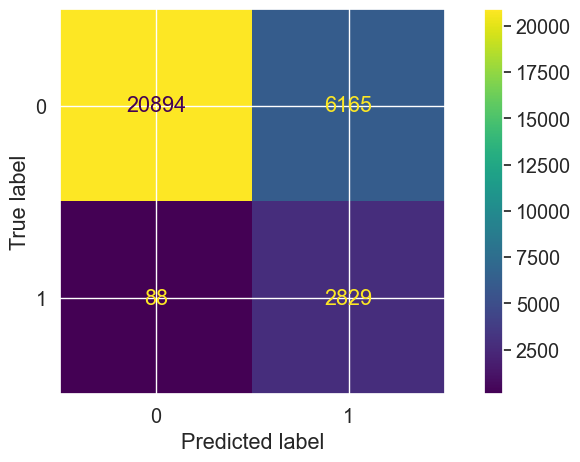

In [59]:
evaluate(y_test, y_pred_forest, RFC)
recall_list.append(recall_score(y_test, y_pred_forest))

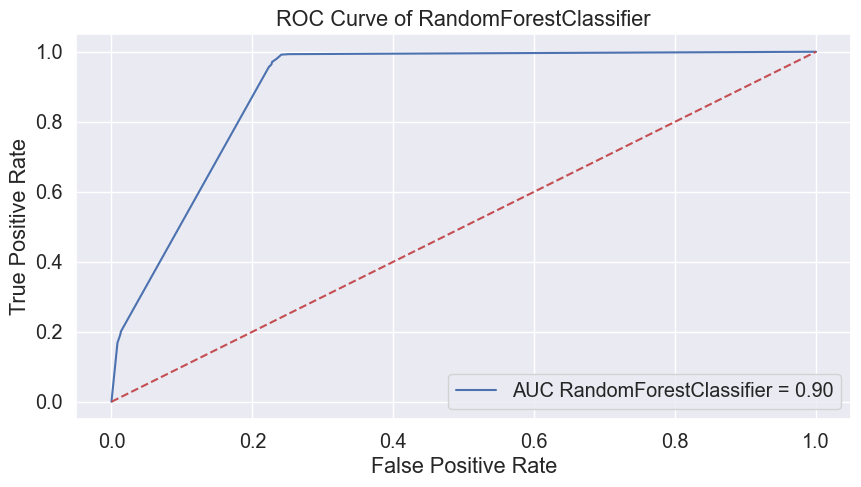

In [60]:
auc_forest_GRID = round(roc_curve_plot(y_test, y_pred_proba_forest, 'RandomForestClassifier')*100,2)

XGBOOST

In [61]:
import xgboost as xgb

In [62]:
paramsxgb = {
    'n_estimators': 40,
    'max_depth': 20,
    'gamma': 0.1,
    'booster': 'gbtree',
    'alpha': 2
 }
model_xgb = xgb.XGBClassifier(**paramsxgb)
model_xgb.fit(X_train,y_train)
xgb_pred_p = model_xgb.predict_proba(X_test)
xgb_pred = model_xgb.predict(X_test)
xgb_pred_t = model_xgb.predict(X_train)

Accuracy Score(train): 0.9793581739082949
Accuracy Score(test): 0.9034894582332532
Accuracy Score: 0.9034894582332532
F1_score: 0.521105777189207
Precision: 0.5038412291933418
Recall: 0.5395954748028796
Classification report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95     27059
           1       0.50      0.54      0.52      2917

    accuracy                           0.90     29976
   macro avg       0.73      0.74      0.73     29976
weighted avg       0.91      0.90      0.90     29976



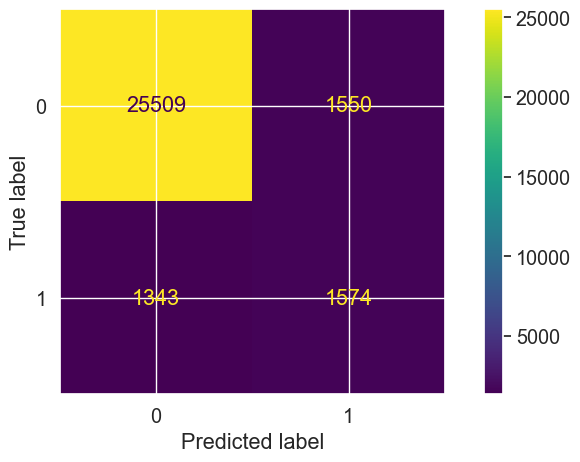

In [63]:
evaluate(y_test, xgb_pred, model_xgb )
recall_list.append(recall_score(y_test, xgb_pred))

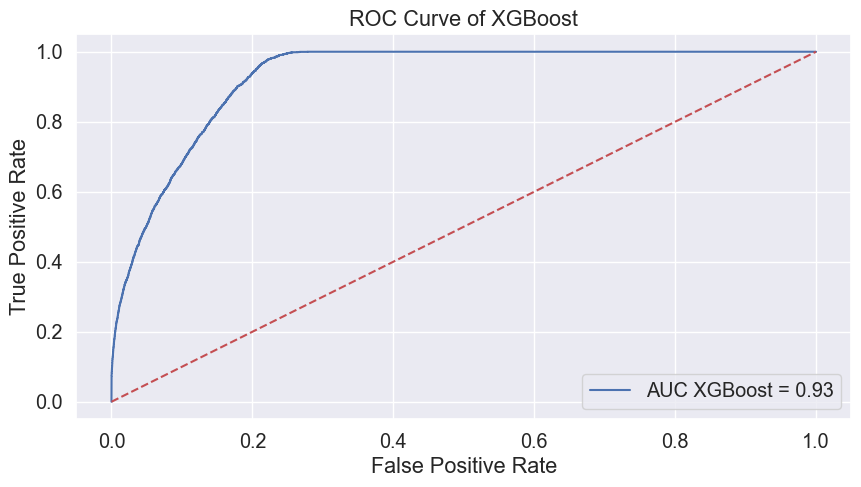

In [64]:
XGBBOOST = round(roc_curve_plot(y_test, xgb_pred_p, 'XGBoost')*100,2)

KNeighborsClassifier

In [65]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
y_pred_proba_knn =  knn.predict_proba(X_test)
y_fit_train_knn =  knn.predict(X_train)

Accuracy Score(train): 0.8505287875202505
Accuracy Score(test): 0.6725713904456899
Accuracy Score: 0.6725713904456899
F1_score: 0.20712496970676145
Precision: 0.13548932572394842
Recall: 0.43949262941378126
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.70      0.79     27059
           1       0.14      0.44      0.21      2917

    accuracy                           0.67     29976
   macro avg       0.53      0.57      0.50     29976
weighted avg       0.84      0.67      0.74     29976

[0.7785395954748029, 0.6074734316078162, 0.9636612958519026, 0.9616043880699349, 0.939664038395612, 0.9698320191978059, 0.5395954748028796, 0.43949262941378126]


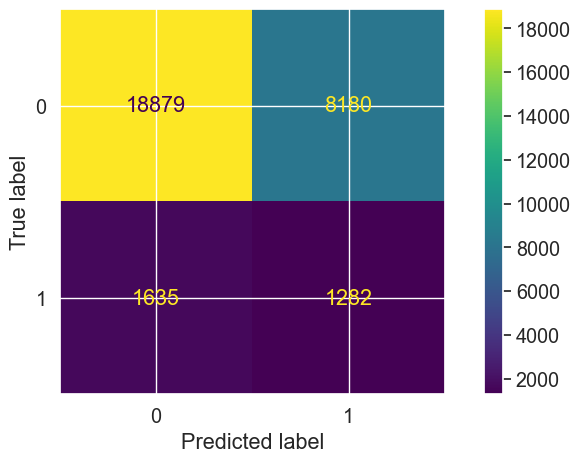

In [66]:
evaluate(y_test, y_pred_knn, knn )

recall_list.append(recall_score(y_test, y_pred_knn))
print(recall_list)

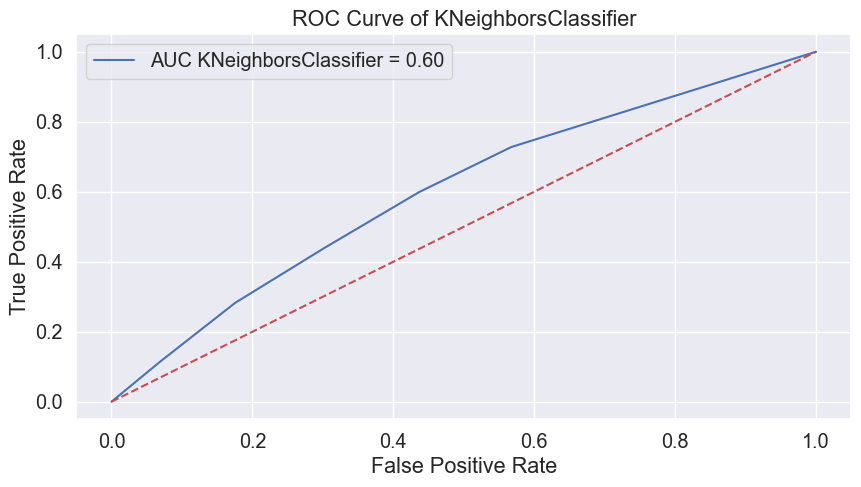

In [67]:
y_scores_knn =  knn.predict_proba(X_test)
auc_knn = round(roc_curve_plot(y_test, y_scores_knn, 'KNeighborsClassifier')*100,2)

AdaBoostClassifier

In [68]:
abc=AdaBoostClassifier()
abc.fit(X_train, y_train)
y_pred_abc = abc.predict(X_test)
y_pred_proba_abc =  abc.predict_proba(X_test)
y_fit_train_abc =  abc.predict(X_train)

Accuracy Score(train): 0.8832389828348836
Accuracy Score(test): 0.797104350146784
Accuracy Score: 0.797104350146784
F1_score: 0.47578003792449575
Precision: 0.3177892918825561
Recall: 0.9461775797051766
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.78      0.87     27059
           1       0.32      0.95      0.48      2917

    accuracy                           0.80     29976
   macro avg       0.66      0.86      0.67     29976
weighted avg       0.93      0.80      0.84     29976

[0.7785395954748029, 0.6074734316078162, 0.9636612958519026, 0.9616043880699349, 0.939664038395612, 0.9698320191978059, 0.5395954748028796, 0.43949262941378126, 0.9461775797051766]


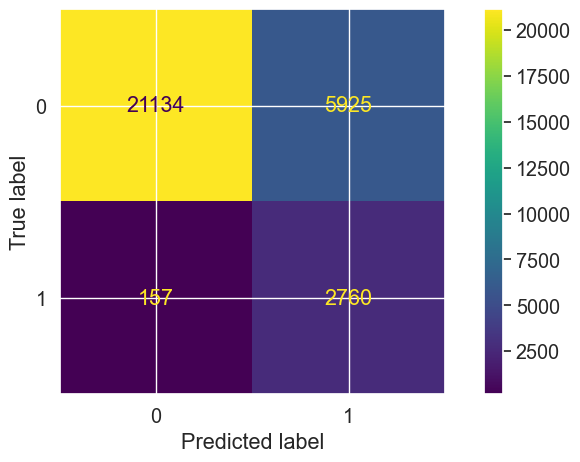

In [69]:
evaluate(y_test, y_pred_abc, abc)

recall_list.append(recall_score(y_test, y_pred_abc))
print(recall_list)

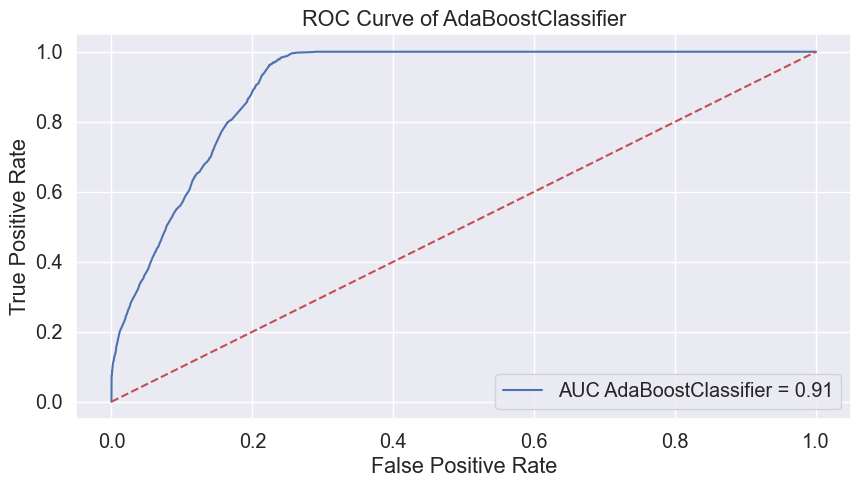

In [70]:
y_scores_abc =  abc.predict_proba(X_test)
auc_abc = round(roc_curve_plot(y_test, y_scores_abc, 'AdaBoostClassifier')*100,2)

In [82]:
def roc_curve_plot(y_test, y_scores, method, color):
    fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = f'AUC {method} = %0.2f' % roc_auc, c= color)
    plt.legend()
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlabel('Odsetek fałszywie pozytywnych', fontsize=20)
    plt.ylabel('Odsetek prawdziwie pozytywnych', fontsize=20)
    plt.title('ROC Curve')
    plt.rcParams['figure.figsize']=[20,7]
    return roc_auc

C:\Users\troch\AppData\Local\Temp\ipykernel_17944\2588897840.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b', label = f'AUC {method} = %0.2f' % roc_auc, c= color)
C:\Users\troch\AppData\Local\Temp\ipykernel_17944\2588897840.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b', label = f'AUC {method} = %0.2f' % roc_auc, c= color)
C:\Users\troch\AppData\Local\Temp\ipykernel_17944\2588897840.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take prece

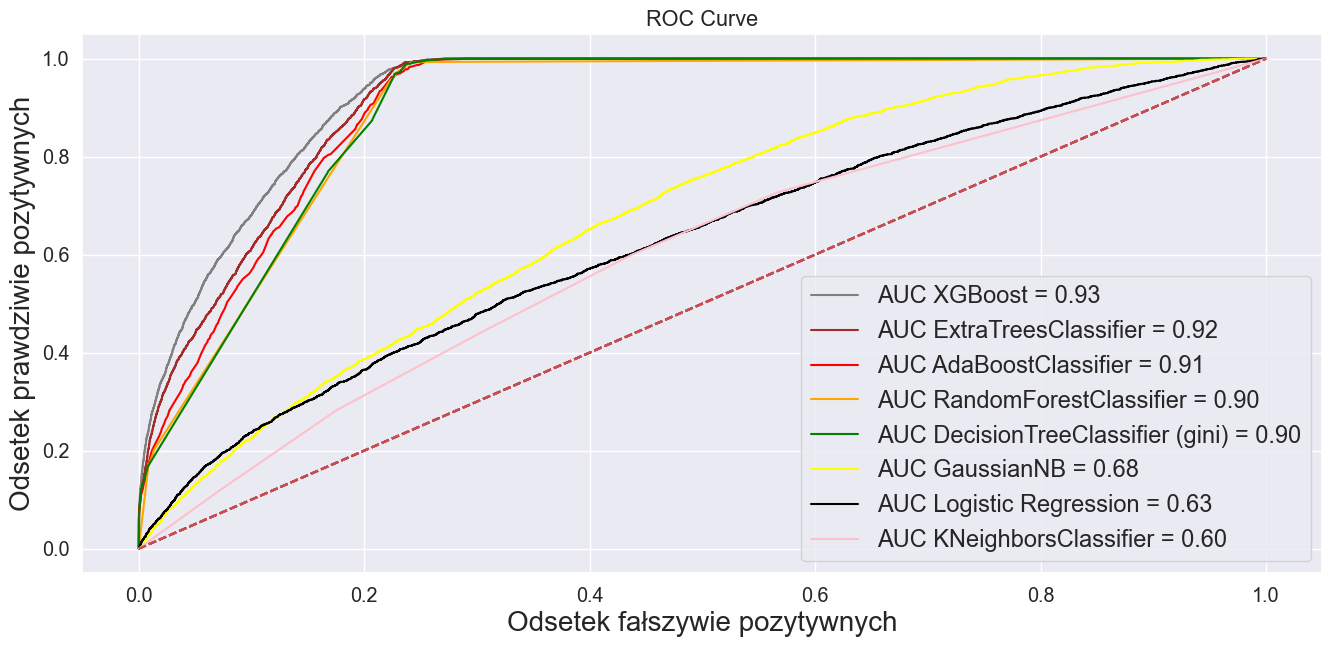

In [83]:
auc_xgb = round(roc_curve_plot(y_test, xgb_pred_p, 'XGBoost', "grey")*100,2)
auc_Extratrees = round(roc_curve_plot(y_test, ET_pred_p, 'ExtraTreesClassifier', "brown")*100,2)
auc_abc = round(roc_curve_plot(y_test, y_pred_proba_abc, 'AdaBoostClassifier', "red")*100,2,)
auc_forest_GRID = round(roc_curve_plot(y_test, y_pred_proba_forest, 'RandomForestClassifier', "orange")*100,2)
auc_tree_g = round(roc_curve_plot(y_test, y_pred_proba_tree_g, 'DecisionTreeClassifier (gini)',  "green")*100,2)
auc_naive = round(roc_curve_plot(y_test, y_pred_proba_naive, 'GaussianNB', "yellow")*100,2)
auc_log_reg = round(roc_curve_plot(y_test, y_pred_proba_log_reg, 'Logistic Regression', "black")*100,2)
auc_knn = round(roc_curve_plot(y_test, y_pred_proba_knn, 'KNeighborsClassifier', "pink")*100,2)
plt.legend(loc="lower right", fontsize=17)
plt.show()

In [73]:
dictionary = {
    log_reg: 'LogisticRegression',
    naive: 'GaussianNB',
    tree_g: 'DecisionTreeClassifier (gini)',
    tree_e: 'DecisionTreeClassifier (entropy)',
    ET_CLF: "ExtraTreesClassifier",
    RFC: 'RandomForestClassifier',
    model_xgb : "XGBoost",
    knn: "KNeighborsClassifier",
    abc: "AdaBoostClassifier",
}

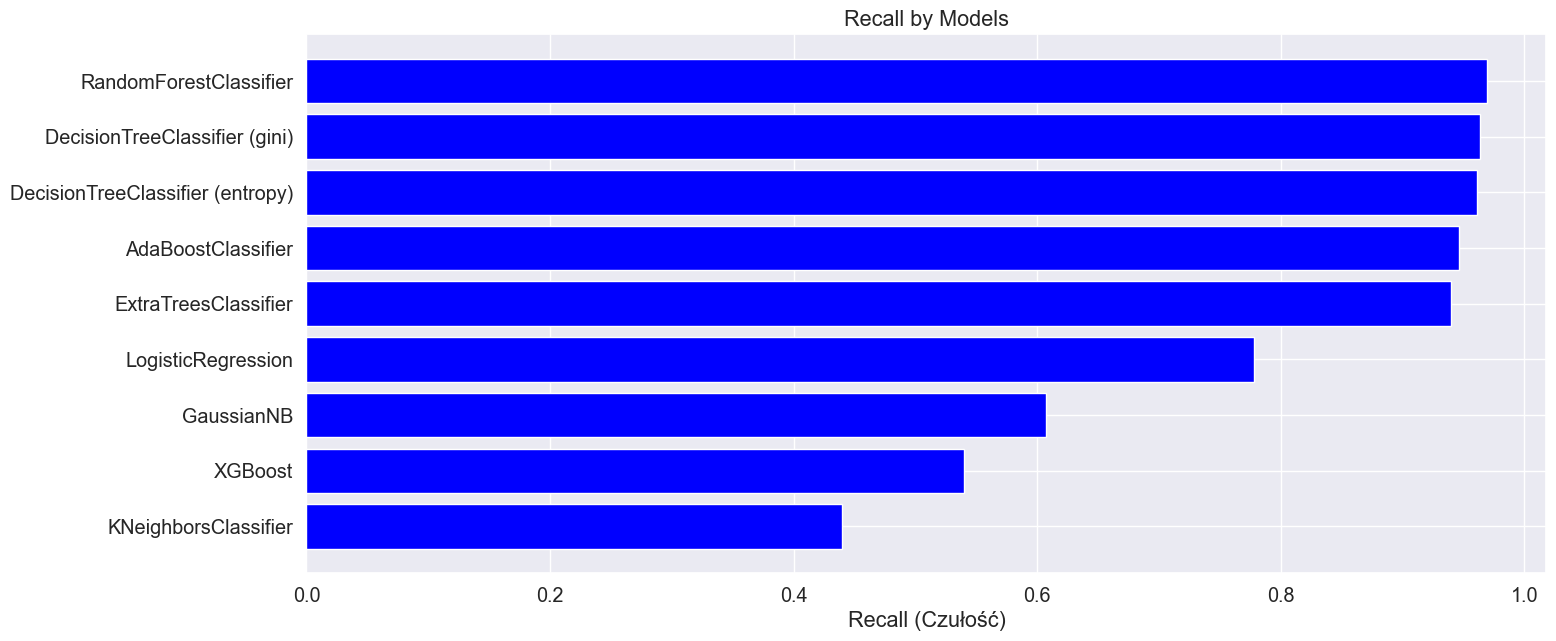

In [74]:


df = pd.DataFrame(recall_list, index=list(dictionary.values()), columns=['recall_list'])
df['recall_list'] = recall_list
df = df.sort_values(by='recall_list', ascending=False)

# Plot the time
plt.barh(df.index, df['recall_list'], color='blue', )
plt.gca().invert_yaxis()
plt.xlabel('Recall (Czułość)')
plt.title('Recall by Models')

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=10)

ax.invert_yaxis()

fig.text(0.9, 0.15, 'Jeeteshgavande30', fontsize=12,
         color='grey', ha='right', va='bottom',
         alpha=0.7)
plt.show() 

In [91]:
df = pd.DataFrame(recall_list, index=list(dictionary.values()), columns=['recall_list'])
df['recall_list'] = recall_list
df = df.sort_values(by='recall_list', ascending=False)
df

,recall_list
RandomForestClassifier,0.969832
DecisionTreeClassifier (gini),0.963661
DecisionTreeClassifier (entropy),0.961604
AdaBoostClassifier,0.946178
ExtraTreesClassifier,0.939664
LogisticRegression,0.778540
GaussianNB,0.607473
XGBoost,0.539595
KNeighborsClassifier,0.439493


<Axes: title={'center': 'Feature Importance for DecisionTree (Gini)'}>

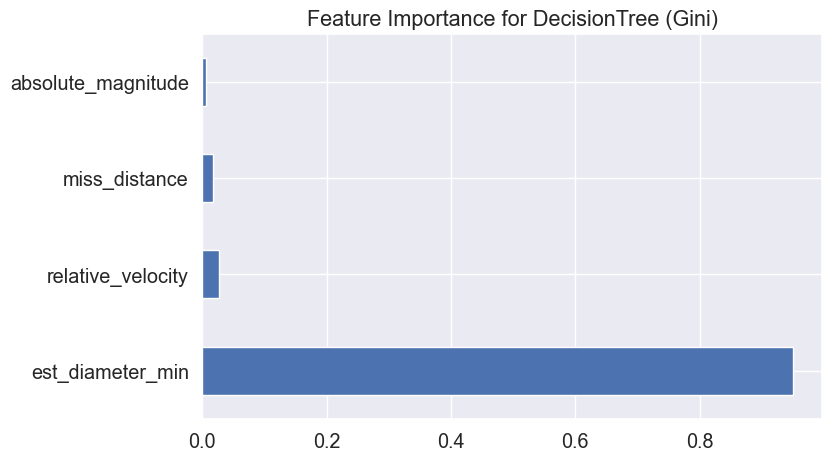

In [90]:


feature_imp_DT_Gini = pd.Series(tree_g.feature_importances_, index = X.columns).sort_values(ascending = False)
feature_imp_DT_Gini.plot(kind='barh', title = 'Feature Importance for DecisionTree (Gini)', figsize=[8,5])

<Axes: title={'center': 'Feature Importance for DecisionTree (Entropy)'}>

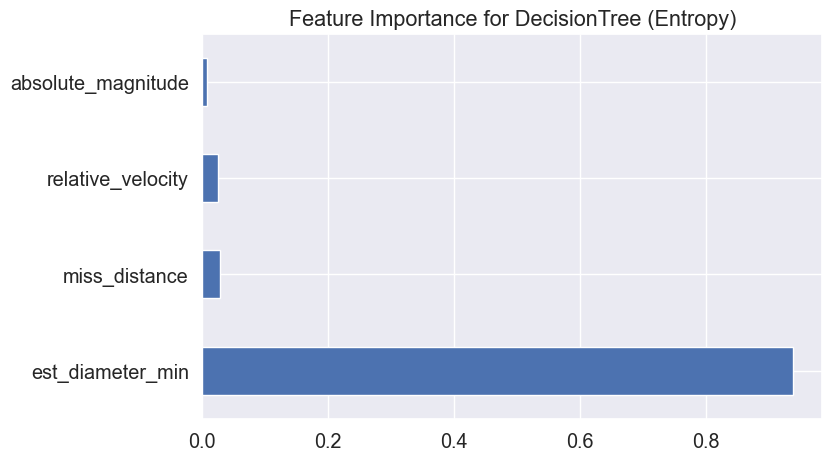

In [89]:
feature_imp_DT_entropy = pd.Series(tree_e.feature_importances_, index = X.columns).sort_values(ascending = False)
feature_imp_DT_entropy.plot(kind='barh', title = 'Feature Importance for DecisionTree (Entropy)', figsize=[8,5])

<Axes: title={'center': 'Feature Importance for RandomForestClassifier'}>

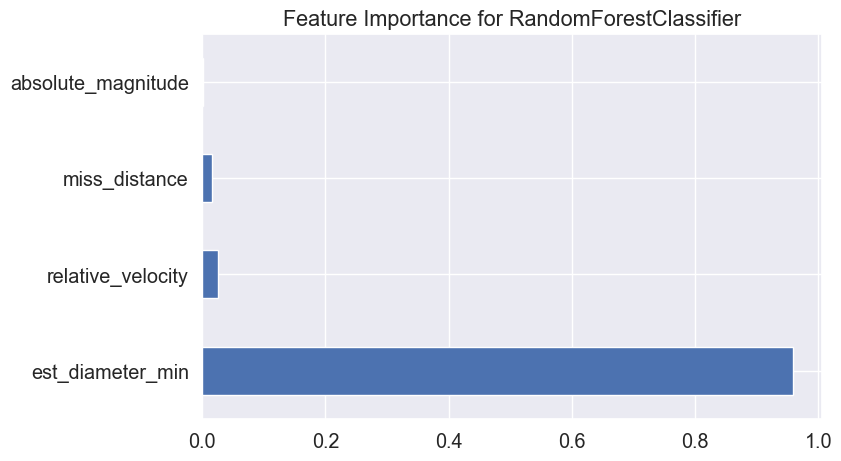

In [86]:
feature_imp_RFC = pd.Series(RFC.feature_importances_, index = X.columns).sort_values(ascending = False)
feature_imp_RFC.plot(kind='barh', title = 'Feature Importance for RandomForestClassifier', figsize=[8,5])

<Axes: title={'center': 'Feature Importance for ExtraTreesClassifier'}>

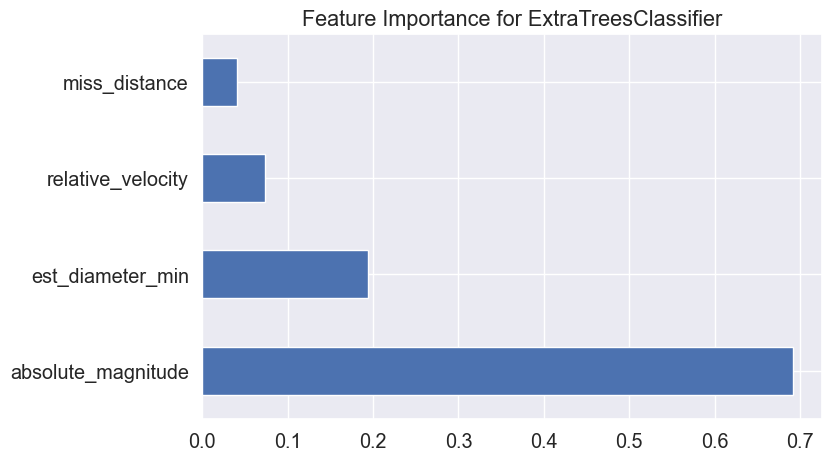

In [79]:
feature_imp_ET_CLF = pd.Series(ET_CLF.feature_importances_, index = X.columns).sort_values(ascending = False)
feature_imp_ET_CLF.plot(kind='barh', title = 'Feature Importance for ExtraTreesClassifier', figsize=[8,5])

<Axes: title={'center': 'Feature Importance for XGBoost'}>

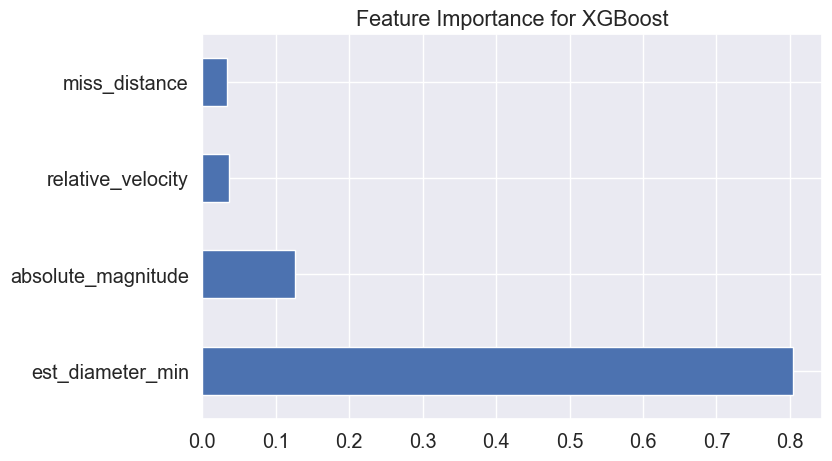

In [87]:
feature_model_xgb = pd.Series(model_xgb.feature_importances_, index = X.columns).sort_values(ascending = False)
feature_model_xgb.plot(kind='barh', title = 'Feature Importance for XGBoost', figsize=[8,5])

<Axes: title={'center': 'Feature Importance for AdaBoostClassifier'}>

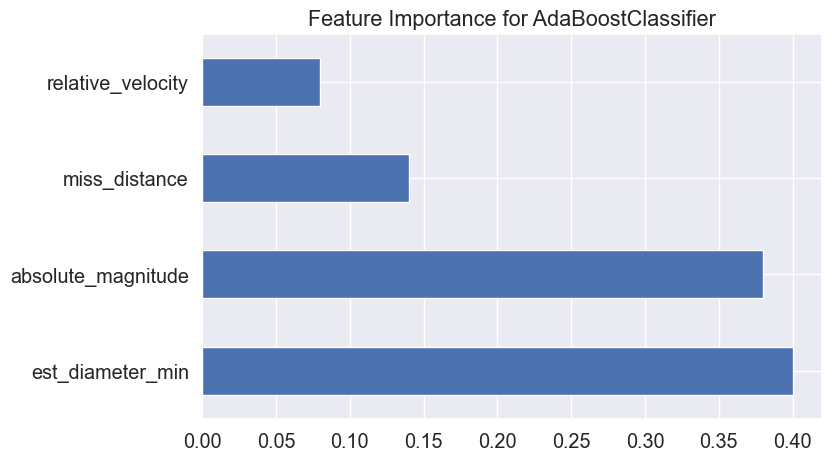

In [88]:
feature_imp_abc = pd.Series(abc.feature_importances_, index = X.columns).sort_values(ascending = False)
feature_imp_abc.plot(kind='barh', title = 'Feature Importance for AdaBoostClassifier', figsize=[8,5])

### Wnioski:
 - Najlepszymi pod względem metryki skuteczności recall okazały się modele drzewiaste, czyli DecisionTree, RandomForest i AdaBoost.
  - Pod względem metryki skuteczności ROC najlepszy okazał się XGBoost następnie ExtraTreesClassifier oraz AdaBoostClassifier.
  - Ze względu na specyfikę projektu cechą mało istotną uznaliśmy czas uzyskania wyników w każdym z modeli. Obiekty wykrywane są dostatecznie wcześnie, aby obliczyć zmienną celu w każdym z najlepszych modeli. 


### Perspektywy rozwoju projektu:
 - Wprowadzenie w życie modelu poprzez budowę aplikacji klasyfikującej obiekt na podstawie danych wprowadzonych przez użytkownika.
 - Utrzymanie i rozwój ww. aplikacji - napisanie kodu monitorowania sprawdzającego wydajność systemu w regularnych odstępach czasu i wysyłający alerty, gdy wydajność spadnie.
 - Trenowanie regularne modelu za pomocą świeżych danych (w miarę możliwości zautomatyzowanie procesu).



